Bayesian Inference by Application to Simple Linear Regression
=============================================================

Simple linear regression is used to illustrate Bayesian inference, using
the Gibbs sampler. The Gibbs sampler is used to draw samples from the
posterior distribution of the intercept, the slope and the residual
variance.

The Model
---------

Consider the linear model:

$$y_{i}=\beta_{0}+x_{i}\beta_{1}+e_{i}. \tag{35}$$

where for observation $i$, $y_{i}$ is the value of the dependent
variable, $\beta_{0}$ is the intercept, $x_{i}$ is the value of the
independent variable and $e_{i}$ is a residual. Flat priors are used for
the intercept and slope, and the residuals are assumed to be identically
and independently distributed normal random variables with mean zero and
variance $\sigma_{e}^{2}.$ A scaled inverted chi-square prior is used
for $\sigma_{e}^{2}.$

Simulation of Data
------------------

In [4]:
using Distributions
using StatsBase

In [5]:
n = 200 #number of observations
k = 1  #number of covariates

x = sample([0,1,2],(n,k))
X = [ones(Int64,n) x]

betaTrue = [1,2]
y = X*betaTrue+ randn(n);

Least Squares Estimation
------------------------

In matrix notation, the model (35) is

$$\mathbf{y}=\mathbf{X}\mathbf{\beta}+\mathbf{e},$$ where
$$\mathbf{X}=\left[\begin{array}{cc}
1 & x_{1}\\
1 & x_{2}\\
\vdots & \vdots\\
1 & x_{n}
\end{array}\right].$$ Then, the least-squares estimator of
$\mathbf{\beta}$ is
$$\mathbf{\hat{\mathbf{\beta}}}=(\mathbf{X}'\mathbf{X})^{-1}\mathbf{X}'\mathbf{y},$$
and the variance of this estimator is
$$Var(\hat{\mathbf{\mathbf{\beta}}})=(\mathbf{X}'\mathbf{X})^{-1}\sigma_{e}^{2}.$$

### Calculations in Julia:

In [6]:
XPX = X'X
rhs = X'y
XPXi= inv(XPX)
println(XPXi)

[0.014328960645812312 -0.008678102926337033
 -0.008678102926337033 0.008072653884964682]


In [7]:
betaHat = XPXi*rhs
println(betaHat)

[0.8871642409759968,2.0840804836041267]


In [8]:
eHat = y - X*betaHat
resVar = eHat'eHat/(n-2)
println(resVar)

[1.02798325102907]


Bayesian Inference
------------------

Consider making inferences about $\mathbf{\beta}$ from
$f(\mathbf{\beta}|\mathbf{y},\sigma_{e}^{2}).$ By using the Bayes
theorem, this conditional density is written as


$$\begin{eqnarray}
f(\mathbf{\beta}|\mathbf{y},\sigma_{e}^{2}) & = & \frac{f(\mathbf{y}|\mathbf{\beta},\sigma_{e}^{2})f(\mathbf{\beta})f(\sigma_{e}^{2})}{f(\mathbf{y},\sigma_{e}^{2})}\nonumber \\
 & \propto & f(\mathbf{y}|\mathbf{\beta},\sigma_{e}^{2})f(\mathbf{\beta})f(\sigma_{e}^{2})\nonumber \\
 & \propto & f(\mathbf{y}|\mathbf{\beta},\sigma_{e}^{2})\nonumber \\
 & = & (2\pi\sigma_{e}^{2})^{-n/2}\exp\left\{ -\frac{1}{2}\frac{(\mathbf{y}-\mathbf{X}\mathbf{\beta})'(\mathbf{y}-\mathbf{X}\mathbf{\beta})}{\sigma_{e}^{2}}\right\}\tag{36}
\end{eqnarray}$$

which looks like the $n$-dimensional normal density of $\mathbf{y}$ with
mean $\mathbf{X}\mathbf{\beta}$ and covariance matrix
$\mathbf{I}\sigma_{e}^{2}.$ But,
$f(\mathbf{\beta}|\mathbf{y},\sigma_{e}^{2})$ should be a
two-dimensional density. So, the quadratic
$Q=(\mathbf{y}-\mathbf{X}\mathbf{\beta})'(\mathbf{y}-\mathbf{X}\mathbf{\beta})$
in the exponent of (36) is rearranged as

$$\begin{eqnarray}
Q & = & (\mathbf{y}-\mathbf{X}\mathbf{\beta})'(\mathbf{y}-\mathbf{X}\mathbf{\beta})\\
 & = & \mathbf{y}'\mathbf{y}-2\mathbf{y}'\mbox{X}\mathbf{\beta}+\mathbf{\beta}'(\mathbf{X}'\mathbf{X})\mathbf{\beta}\\
 & = & \mathbf{y}'\mathbf{y}+(\mathbf{\beta}-\hat{\mathbf{\beta}})'(\mathbf{X}'\mathbf{X})(\mathbf{\beta}-\hat{\mathbf{\beta}})-\hat{\mathbf{\beta}}'(\mathbf{X}'\mathbf{X})\hat{\mathbf{\beta}},
\end{eqnarray}$$

where $\hat{\mathbf{\beta}}$ is the solution to
$(\mathbf{X}'\mathbf{X})\hat{\mathbf{\beta}}=\mathbf{X}'\mathbf{y}$,
which is the least-squares estimator of $\mathbf{\beta}$. In this
expression, only the second term depends on $\mathbf{\beta}$. Thus,
$f(\mathbf{\beta}|\mathbf{y},\sigma_{e}^{2})$ can be written as

$$
f(\mathbf{\beta}|\mathbf{y},\sigma_{e}^{2})\propto\exp\left\{ -\frac{1}{2}\frac{(\mathbf{\beta}-\hat{\mathbf{\beta}})'(\mathbf{X}'\mathbf{X})(\mathbf{\beta}-\hat{\mathbf{\beta}})}{\sigma_{e}^{2}}\right\},
$$

which can be recognized as proportional to the density for a
two-dimensional normal distribution with mean $\hat{\mathbf{\beta}}$
and variance $(\mathbf{X}'\mathbf{X})^{-1}\sigma_{e}^{2}$. Thus, in this
simple setting, the posterior mean of $\mathbf{\beta}$ is given by
the least-squares estimate, and drawing samples from the posterior are
not needed. But, to illustrate the Gibbs sampler, we will apply it to
this simple example.

### Gibbs Sampler for $\mathbf{\beta}$

The simple regression model can be written as
$$\mathbf{y=}\mathbf{1}\beta_{0}+\mathbf{x}\beta_{1}+\mathbf{e}.$$ In
the Gibbs sampler, $\beta_{0}$ is sampled from its full-conditional
posterior: $f(\beta_{0}|\mathbf{y},\beta_{1},\sigma_{e}^{2}).$ This
conditional distribution is computed for the current values of
$\beta_{1}$ and $\sigma_{e}^{2}.$ So, we can write the model as
$$\mathbf{w}_{0}=\mathbf{1}\beta_{0}+\mathbf{e},$$ where
$\mathbf{w}_{0}=\mathbf{y}-\mathbf{x}\beta_{1}.$ Then, the least-squares
estimator of $\beta_{0}$ is
$$\hat{\beta}_{0}=\frac{\mathbf{1}'\mathbf{w}_{0}}{\mathbf{1}'\mathbf{1}},$$
and the variance of this estimator is
$$Var(\hat{\beta_{0}})=\frac{\sigma_{e}^{2}}{\mathbf{1}'\mathbf{1}}.$$
By applying the strategy used to derive
$f(\mathbf{\beta}|\mathbf{y},\sigma_{e}^{2})$ above, the
full-conditional posterior for $\beta_{0}$ can be shown to be a normal
distribution with mean $\hat{\beta_{0}}$ and variance
$\frac{\sigma_{e}^{2}}{\mathbf{1}'\mathbf{1}}.$ Similarly, the
full-conditional posterior for $\beta_{1}$ is a normal distribution with
mean
$$\hat{\beta}_{1}=\frac{\mathbf{x}'\mathbf{w}_{1}}{\mathbf{x}'\mathbf{x}}$$
and variance $\frac{\sigma_{e}^{2}}{\mathbf{x}'\mathbf{x}}$, where
$\mathbf{w}_{1}=\mathbf{y}-1\beta_{0}.$ In the calculations below, we
will use the true value of $\sigma_{e}^{2}.$

### Calculations in Julia:

In [9]:
# loop for Gibbs sampler
niter = 10000      # number of samples
b     = [0.0, 0.0] # initial value of b
meanB = [0.0, 0.0]
a=Float64[]


for iter = 1:niter
    
    # sampling intercept
    w = y - X[:,2] * b[2]
    x = X[:,1]
    xpxi = 1/(x'x)[1]
    bHat = (xpxi*x'w)[1]
    b[1] = rand(Normal(bHat, sqrt(xpxi))) # using residual var = 1 
    
    # sampling slope
    w = y - X[:,1]*b[1]
    x = X[:,2]
    xpxi = 1/(x'x)[1]
    bHat = (xpxi*x'w)[1]
    b[2] = rand(Normal(bHat, sqrt(xpxi))) # using residual var = 1 
    meanB = meanB + b   
    push!(a,b[2])
    
    if ((iter%1000) == 0)
        @printf("Intercept = %6.3f \n", meanB[1]/iter)
        @printf("Slope     = %6.3f \n", meanB[2]/iter)
    end
end

Intercept =  0.904 
Slope     =  2.071 
Intercept =  0.899 
Slope     =  2.074 
Intercept =  0.896 
Slope     =  2.076 
Intercept =  0.892 
Slope     =  2.080 
Intercept =  0.892 
Slope     =  2.080 
Intercept =  0.893 
Slope     =  2.079 
Intercept =  0.892 
Slope     =  2.081 
Intercept =  0.891 
Slope     =  2.081 
Intercept =  0.891 
Slope     =  2.081 
Intercept =  0.889 
Slope     =  2.082 


In [10]:
using Gadfly

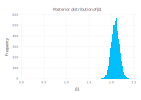

In [11]:
plot(x=a, Geom.histogram, 
Guide.title("Posterior distribution of β1"),
Guide.ylabel("Frequency"),
Guide.xlabel("β1"))

### Full-conditional Posterior for $\sigma_{e}^{2}$

Recall that we assumed a scaled inverted chi-square prior for
$\sigma_{e}^{2}$. The density function for this is:

$$f(\sigma_{e}^{2})=\frac{(S_{e}^{2}\nu_{e}/2)^{\nu_{e}/2}}{\Gamma(\nu_{e}/2)}(\sigma_{e}^{2})^{-(2+\nu_{e})/2}\exp\left\{ -\frac{\nu_{e}S_{e}^{2}}{2\sigma_{e}^{2}}\right\},\tag{37}$$

where $S_{e}^{2}$ and $\nu_{e}$ are the scale and the degrees of freedom
parameters for this distribution. Applying Bayes theorem to combine this
prior with the “likelihood” (given in (36)), the full-conditional
posterior for the residual variance can be written as

$$\begin{aligned}
f(\sigma_{e}^{2}|\mathbf{y},\mathbf{\beta}) 
& = \frac{f(\mathbf{y}|\mathbf{\beta},\sigma_{e}^{2})f(\mathbf{\beta})f(\sigma_{e}^{2})}{f(\mathbf{y},\mathbf{\beta})}\nonumber \\
& \propto f(\mathbf{y}|\mathbf{\beta},\sigma_{e}^{2})f(\mathbf{\beta})f(\sigma_{e}^{2})\nonumber \\
& \propto (\sigma_{e}^{2})^{-n/2}\exp\left\{ -\frac{1}{2}\frac{(\mathbf{y}-\mathbf{X}\mathbf{\beta})'(\mathbf{y}-\mathbf{X}\mathbf{\beta})}{\sigma_{e}^{2}}\right\} \nonumber \\
& \times (\sigma_{e}^{2})^{-(2+\nu_{e})/2}\exp\left\{ -\frac{\nu_{e}S_{e}^{2}}{2\sigma_{e}^{2}}\right\} \nonumber \\
& = (\sigma_{e}^{2})^{-(n+2+\nu_{e})/2}\exp\left\{ -\frac{(\mathbf{y}-\mathbf{X}\mathbf{\beta})'(\mathbf{y}-\mathbf{X}\mathbf{\beta})+\nu_{e}S_{e}^{2}}{2\sigma_{e}^{2}}\right\}.
\end{aligned}\tag{38}$$

Comparing (38) with (37), can see that it is proportional
to a scaled inverse chi-squared density with $\tilde{\nu}_{e}=n+\nu_{e}$
degrees of freedom and
$\tilde{S_{e}^{2}}=\frac{(\mathbf{y}-\mathbf{X}\mathbf{\beta})'(\mathbf{y}-\mathbf{X}\mathbf{\beta})+\nu_{e}S_{e}^{2}}{\tilde{\nu_{e}}}$
scale parameter. A sample from this density can be obtained as
$\frac{(\mathbf{y}-\mathbf{X}\mathbf{\beta})'(\mathbf{y}-\mathbf{X}\mathbf{\beta})+\nu_{e}S_{e}^{2}}{\chi_{\tilde{\nu_{e}}}^{2}}$,
where $\chi_{\tilde{\nu_{e}}}^{2}$ is a chi-squared random variable with
$\tilde{\nu_{e}}$ degrees of freedom. 

### Exercise

In the Julia script given here, the simulated value of the residual variance
was used in the sampling of $\mathbf{\beta}$. Extend this script to
also sample $\sigma_{e}^{2}$ from its full-conditional posterior given
above. In Julia, rand(Chisq($\nu$),1) gives a chi-squared random variable with
$\nu$ degrees of freedom.

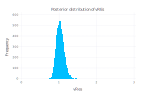

In [12]:
# loop for Gibbs sampler
niter = 10000      # number of samples
b     = [0.0, 0.0] # initial value of b
meanB = [0.0, 0.0]
a     = Float64[]
vRes  = 1.0
νRes  = 5
S2Res = vRes*(νRes - 1)/νRes
n     = size(X,1)
for iter = 1:niter
    
    # sampling intercept
    w = y - X[:,2] * b[2]
    x = X[:,1]
    xpxi = 1/(x'x)[1]
    bHat = (xpxi*x'w)[1]
    b[1] = rand(Normal(bHat, sqrt(xpxi*vRes))) 
    
    # sampling slope
    w = y - X[:,1]*b[1]
    x = X[:,2]
    xpxi = 1/(x'x)[1]
    bHat = (xpxi*x'w)[1]
    b[2] = rand(Normal(bHat, sqrt(xpxi*vRes)))
    meanB = meanB + b 
    
    # sampling vRes
    e = y - X*b
    SSE = (e'e)[1]
    vRes = (SSE + νRes*S2Res)/rand(Chisq(n+νRes),1)[1]
    push!(a,vRes)

end
plot(x=a, Geom.histogram, 
Guide.title("Posterior distribution of vREs"),
Guide.ylabel("Frequency"),
Guide.xlabel("vRes"))

Model with Normal Prior for Slope
---------------------------------

Consider the simple regression model that can be written as
$$\mathbf{y=}\mathbf{1}\beta_{0}+\mathbf{x}\beta_{1}+\mathbf{e}.$$ 
Here we consider a model with a flat prior for $\beta_{0}$ and a normal
prior for the slope: 

$$\beta_{1}\sim N(0,\sigma_{\beta}^{2}),$$ 

where $\sigma_{\beta}^{2}$ is assumed to be known. 

Then, the full-conditional
posterior for $\theta'=[\mathbf{\beta},\sigma_{e}^{2}]$ is

$$\begin{aligned}
f(\mathbf{\theta}|\mathbf{y}) 
& \propto f(\mathbf{y}|\mathbf{\theta})f(\mathbf{\theta})\\
& \propto \left(\sigma_{e}^{2}\right)^{-n/2}\exp\left\{ -\frac{(\mathbf{y}-\mathbf{1}\beta_{0}-\mathbf{x}\beta_{1})'(\mathbf{y}-\mathbf{1}\beta_{0}-\mathbf{x}\beta_{1})}{2\sigma_{e}^{2}}\right\} \\
& \times \left(\sigma_{\beta}^{2}\right)^{-1/2}\exp\left\{ -\frac{\beta_{1}^{2}}{2\sigma_{\beta}^{2}}\right\} \\
& \times (\sigma_{e}^{2})^{-(2+\nu_{e})/2}\exp\left\{ -\frac{\nu_{e}S_{e}^{2}}{2\sigma_{e}^{2}}\right\} .\\
\end{aligned}$$

### Full-conditional for $\beta_{1}$:

The full-conditional for $\beta_{1}$ is obtained by dropping all terms
and factors that do not involve $\beta_{1}$:

$$\begin{aligned}
f(\beta_{1}|\text{ELSE}) 
& \propto \exp\left\{ -\frac{(\mathbf{y}-\mathbf{1}\beta_{0}-\mathbf{x}\beta_{1})'(\mathbf{y}-\mathbf{1}\beta_{0}-\mathbf{x}\beta_{1})}{2\sigma_{e}^{2}}\right\} \times \exp\left\{ -\frac{\beta_{1}^{2}}{2\sigma_{\beta}^{2}}\right\} \\
& \propto \exp\left\{ -\frac{\mathbf{w}'\mathbf{w}-2\mathbf{w}'\mathbf{x}\beta_{1}+\beta_{1}^{2}(\mathbf{x}'\mathbf{x}+\sigma_{e}^{2}/\sigma_{\beta}^{2})}{2\sigma_{e}^{2}}\right\} \\
& \propto \exp\left\{ -\frac{\mathbf{w}'\mathbf{w}-(\beta_{1}-\hat{\beta}_{1})^{2}(\mathbf{x}'\mathbf{x}+\sigma_{e}^{2}/\sigma_{\beta}^{2})-\hat{\beta}_{1}^{2}(\mathbf{x}'\mathbf{x}+\sigma_{e}^{2}/\sigma_{\beta}^{2})}{2\sigma_{e}^{2}}\right\} \\
& \propto \exp\left\{ -\frac{(\beta_{1}-\hat{\beta}_{1})^{2}}{\frac{2\sigma_{e}^{2}}{(\mathbf{x}'\mathbf{x}+\sigma_{e}^{2}/\sigma_{\beta}^{2})}}\right\} ,
\end{aligned}$$

where
$$\hat{\beta}_{1}=\frac{\mathbf{x}'\mathbf{w}}{(\mathbf{x}'\mathbf{x}+\sigma_{e}^{2}/\sigma_{\beta}^{2})},$$
and $\mathbf{w}=\mathbf{y}-\mathbf{1}\beta_{0}.$ So, the
full-conditional posterior for $\beta_{1}$ is a normal distribution with
$ $mean $\hat{\beta}_{1}$ and variance
$\frac{\sigma_{e}^{2}}{(\mathbf{x}'\mathbf{x}+\sigma_{e}^{2}/\sigma_{\beta}^{2})}.$

### Exercise

 1.  In the following we will use a normal distribution with mean zero and variance 3 as the prior 
     for $\beta_{1}$. Use Julia to simulate a vector of 1000 values for $\beta_{1}$ from a
     this prior. Plot a histogram of these values. 

2.  Use $\beta_{0}=1$, $\beta_{1}=2$ and $\sigma_{e}^{2}=5$, to generate a vector of observations, $\mathbf{y},$ 
    that follows a simple linear regression model. 

3.  Use the Gibbs sampler to draw 10,000 samples for $\beta_{1}$ from
    its posterior distribution.

    1.  Compute the mean and variance of the sampled values.

    2.  Draw a histogram of the sampled values. Compare with prior.   

### Simulation of the data

In [32]:
n = 200 # number of observations
k = 1   # number of covariates

x = sample([0,1,2],(n,k))
X = [ones(Int64,n) x]

betaTrue = [1,2]
y = X*betaTrue+ randn(n)*sqrt(5.0);

### Prior Distibution of  $\beta_1$

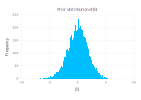

In [23]:
prior = randn(10000)*sqrt(3.0)
plot(x=prior, Geom.histogram, 
Guide.title("Prior distribution of β1"),
Guide.ylabel("Frequency"),
Guide.xlabel("β1"))

###  Posterior Distibution of  $\beta_1$

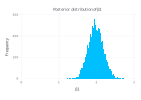

In [33]:
# loop for Gibbs sampler
niter = 10000      # number of samples
b     = [0.0, 0.0] # initial value of b
meanB = [0.0, 0.0]
a     = Float64[]
vB1   = 3.0
vRes  = 1.0
νRes  = 5
S2Res = vRes*(νRes - 1)/νRes
n     = size(X,1)
for iter = 1:niter
    
    λ = vRes/vB1
    
    # sampling intercept
    w = y - X[:,2] * b[2]
    x = X[:,1]
    xpxi = 1/(x'x)[1]
    bHat = (xpxi*x'w)[1]
    b[1] = rand(Normal(bHat, sqrt(xpxi*vRes))) 
    
    # sampling slope
    w = y - X[:,1]*b[1]
    x = X[:,2]
    xpxi = 1/(x'x + λ)[1]
    bHat = (xpxi*x'w)[1]
    b[2] = rand(Normal(bHat, sqrt(xpxi*vRes)))
    meanB = meanB + b 
    
    # sampling vRes
    e = y - X*b
    SSE = (e'e)[1]
    vRes = (SSE + νRes*S2Res)/rand(Chisq(n+νRes),1)[1]
    push!(a,b[2])

end
plot(x=a, Geom.histogram, 
Guide.title("Posterior distribution of β1"),
Guide.ylabel("Frequency"),
Guide.xlabel("β1"))

In [34]:
using DataFrames
df = DataFrame()
df[:PP] = [fill("Prior",10000); fill("Posterior",10000)]
df[:b1] = [prior; a];

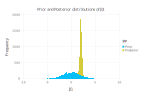

In [35]:
plot(df, x="b1", Geom.histogram, 
Guide.title("Prior and Posterior distributions of β1"),
Guide.ylabel("Frequency"),
Guide.xlabel("β1"),
color = "PP")